# As we search through TESS sectors for transit-like events, we will have to do very careful follow up analysis to make sure what we are detecting is actually due to a planetary eclipse.

Attached in this directory are two light curves that look pretty convincing. Let's check them out.


In [3]:
# First let's import our functions and modules:

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec
import time
import batman
from astropy.stats import BoxLeastSquares
from transitleastsquares import period_grid

#custom binning function
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time))
    timefit = time[good]
    fluxfit = flux[good]
    errfit  = error[good]
    timemax = np.max(timefit)
    timemin = np.min(timefit)
    npoints = len(timefit)
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
    bintime = np.full((nbins,), np.nan)
    binflux = np.full((nbins,), np.nan)
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
        if tobin[0] != -1:
    #     inverse variance weighted means
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime))
    bintime = bintime[good2]
    binflux = binflux[good2]
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #these are annoying.

from transitleastsquares import transitleastsquares
from transitleastsquares import catalog_info
from transitleastsquares import transit_mask


# These are used to employ your computers operating system (os) to
# search through your directories for specific files.
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
from scipy.signal import savgol_filter

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
#     print ("criterion: ", criterion)
#     print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)

def SmoothAndRemove(time,flux,flux_error,iterations):
    
    cad = time[1]-time[0]
    #now let's define a window size to smooth our data with:

    window_size = int(5.0/cad) #number of data points in 5 hours
    if (window_size % 2) == 0: #must be odd. If not, there will be an error
        window_size = window_size+1

    
    # lets smooth for a total of 10 times. Experiment with more or less iterations:
    
    o = np.ones(len(flux), dtype=bool)
    for i in range(10):  #Note: You can place a for-loop inside a for-loop!
        y_prime = np.interp(time, time[o], flux[o])
        smooth = savgol_filter(y_prime, window_size, polyorder=3)
        resid = flux - smooth +1 #add the one to have it centered on 1.0 instead of 0.0
        sigma = np.sqrt(np.mean(resid**2)) #root mean square (RMS for short)
        o0 = np.abs(resid) < 3*sigma #this is shorthand for: -3*sigma < resid < 3*sigma
        if o.sum() == o0.sum():
            o = o0
            break
        o = o0

    # Only discard positive outliers
    o = resid < 3.0*sigma

    #removing outliers with Chauvenet's criterion after smoothing
    newtime,newflux,newflux_error = ChauventsCriteron(time,resid,flux_error)
    
    return newtime,newflux,newflux_error,window_size

# Next, let's write a function for our BLS searches and plotting commands:
def BLS(time,flux,flux_error,ID,minP,minDur,maxDur,window_size,SDE_threshold):
    
    LCduration = time[-1]-time[0] #duration of light curve (last minus first data point)
    maxP=LCduration
    
    qld, R_star, R_star_min, R_star_max, M_star, M_star_min, M_star_max = catalog_info(TIC_ID=int(ID))   
    #^^^ grabbing stellar information from MAST catalogs
    
    if np.isfinite(R_star)==True or np.isfinite(M_star)==True: #checks to see if stellar information is unknown in MAST catalogs
    
        #creating list of orbital periods to model with
        periods = period_grid(R_star=R_star, M_star=M_star, time_span=LCduration, period_min=minP, period_max=maxP)#,oversampling_factor=10)

        durations = np.linspace(minDur,maxDur,25)

        #start BLS search
        bls = BoxLeastSquares(time, flux) #just for specific target
        bls_power = bls.power(periods, durations)

        bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)
        


        index = np.argmax(bls_power.power) #finds the index corresponding to the strongest peak in BLS power spectrum
        BLS_periods=bls_power.period[index]
        BLS_t0s=bls_power.transit_time[index]
        BLS_depths=bls_power.depth[index]
        dur = minDur #0.5

        #creating the best fit box model to our data
        bls_model=bls.model(time,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])



        #for functions, it is useful to have some saved outputs. These are ones I think may be useful to keep track of.
        return bls, bls_power, bls_SDE, BLS_periods, BLS_t0s, BLS_depths, bls_model
    
#note bls_period = bls_power.period 
def PlotBLSResults(bls_period, bls_SDE,BLS_periods,ID,Sector,Camera,CCD,window_size, time,flux,flux_error, bls_model, BLS_t0s):
    fs=10
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.5,hspace=0.5)

    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1])

    ax1.plot(np.log10(bls_period), bls_SDE, "b")
    ax1.axvline(np.log10(BLS_periods), color="red", lw=6, alpha=0.5) #this is our strongest peak
    ax1.annotate("period = {0:.4f} days".format(BLS_periods),(0, 1), xycoords="axes fraction",
                            xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
    ax1.set_ylabel("SDE",fontsize=fs)
    ax1.set_xlim(np.log10(np.min(bls_period))-0.1, np.log10(np.max(bls_period)+0.1))
    # plt.ylim(bls_SDE.min()-0.25, bls_SDE.max()+0.25)
    ax1.set_xlabel("log(Period ( days))",fontsize=fs)
    ax1.set_title(("TIC "+ID+" "+Sector+" Camera "+ Camera+" CCD "+ CCD + "\n Data with Savitsky-Golay filter: window = "+str(window_size)+" data points"))


    ax2.plot(time,flux,color='grey',marker=".",linestyle='none')
    ax2.plot(time,bls_model,'b.')
    ax2.set_xlabel("Time (Julian Date)")
    ax2.set_ylabel("Normalized Relative Flux")

    # Plot the folded transit
    p = BLS_periods
    x_fold = (time - BLS_t0s + 0.5*p) % p - 0.5*p

    #Bin the data
    binsize= 30.0/(60.0*24.0) 
    bint,binf,binfe = Bin_func(x_fold, flux,flux_error,binsize)

    ax3.plot(24*x_fold,flux,color='grey',marker=".",linestyle='none')#,label='smoothed subtracted data')
    ax3.plot(24*bint,binf,'ro')#,label='binned data, 30 min bins'
    ax3.plot(24*x_fold,bls_model,'b.')#,label='BLS model'
    ax3.set_xlabel(" Phase (hours)")
    #         ax3.legend(loc='best')
    ax3.set_xlim(-0.3*24,0.3*24) #+/- 0.2 hours
    fig.tight_layout()
    plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_BLS.png")
    plt.show()    
    
# And let's do the same for TLS
def TLS(time,flux,flux_error,minP,window_size):
    LCduration = time[-1]-time[0] #duration of light curve (last minus first data point)
    maxP=LCduration
    
    tls = transitleastsquares(time,flux)
    tls_power = tls.power(period_min=minP,period_max=maxP,show_progress_bar=False,n_transits_min=3)#,duration_grid_step=2)

    #TLS results
    TLS_periods=tls_power.period
    TLS_t0s=tls_power.T0
    TLS_depths=tls_power.depth
    TLS_SDE=tls_power.power

    #TLS results
#     phase_model = tls_power.model_folded_phase
    TLS_model_time = tls_power.model_lightcurve_time 
    TLS_model = tls_power.model_lightcurve_model #results.model_folded_model <--- old
#     phase = tls_power.folded_phase
#     folded_y = tls_power.folded_y
    
    
    return tls, tls_power, TLS_SDE, TLS_periods, TLS_depths, TLS_t0s,TLS_model_time,TLS_model

# note tls_period = tls_power.periods
def PlotTLSResults(time, flux, flux_error, TLS_periods,TLS_t0s,tls_period,TLS_SDE, ID, Sector, Camera, CCD, window_size,TLS_model_time,TLS_model):
    p = TLS_periods
    x_fold = (time - TLS_t0s + 0.5*p) % p - 0.5*p
    pf_model = (TLS_model_time - TLS_t0s + 0.5*p) % p - 0.5*p

    fs=10
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.5,hspace=0.5)

    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1])

    ax1.plot(np.log10(tls_period), TLS_SDE, "b")
    ax1.axvline(np.log10(TLS_periods), color="red", lw=6, alpha=0.5) #this is our strongest peak
    ax1.annotate("period = {0:.4f} days".format(TLS_periods),(0, 1), xycoords="axes fraction",
                            xytext=(50, -5), textcoords="offset points",va="top", ha="left", fontsize=12)
    ax1.set_ylabel("SDE",fontsize=fs)
    ax1.set_xlim(np.log10(np.min(tls_period))-0.1, np.log10(np.max(tls_period))+0.1)
    # plt.ylim(bls_SDE.min()-0.25, bls_SDE.max()+0.25)
    ax1.set_xlabel("log(Period ( days))",fontsize=fs)
    ax1.set_title(("TIC "+ID+" "+Sector+" Camera "+ Camera+" CCD "+ CCD + "\n Data with Savitsky-Golay filter: window = "+str(window_size)+" data points"))


    ax2.plot(time,flux,color='grey',marker=".",linestyle='none')
    ax2.plot(TLS_model_time,TLS_model,'b.')
    ax2.set_xlabel("Time (Julian Date)")
    ax2.set_ylabel("Normalized Relative Flux")

    #Bin the data
    binsize= 30.0/(60.0*24.0) 
    bint,binf,binfe = Bin_func(x_fold, flux, flux_error,binsize)

    ax3.plot(24*x_fold,flux,color='grey',marker=".",linestyle='none')#,label='smoothed subtracted data')
    ax3.plot(24*bint,binf,'ro')#,label='binned data, 30 min bins'
    ax3.plot(24*pf_model,TLS_model,'b.')#,label='BLS model'
    ax3.set_xlabel(" Phase (hours)")
    #         ax3.legend(loc='best')
    ax3.set_xlim(-0.3*24,0.3*24) #+/- 0.2 hours
    fig.tight_layout()
    plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_TLS.png")
    plt.show()

# Now let's read in our two light curves:

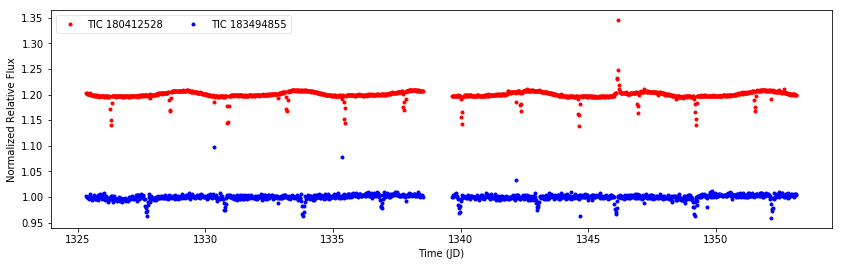

In [21]:

data1 = np.transpose(np.loadtxt("180412528_sector01_3_3.lc"))
data2 = np.transpose(np.loadtxt("183494855_sector01_3_3.lc"))

ID1 = (os.path.basename("180412528_sector01_3_3.lc").split)('_')[0] 
Sector1 = "S"+(os.path.basename("180412528_sector01_3_3.lc").split)('_')[1][1:] 
Camera1 = (os.path.basename("180412528_sector01_3_3.lc").split)('_')[2] 
CCD1 = (os.path.basename("180412528_sector01_3_3.lc").split)('_')[3][-4]

ID2 = (os.path.basename("183494855_sector01_3_3.lc").split)('_')[0]
Sector2 = "S"+(os.path.basename("183494855_sector01_3_3.lc").split)('_')[1][1:]
Camera2 = (os.path.basename("183494855_sector01_3_3.lc").split)('_')[2] 
CCD2 = (os.path.basename("183494855_sector01_3_3.lc").split)('_')[3][-4]

t1= data1[0];   t2 = data2[0]
m1 = data1[1];   m2 = data2[1]
me1 = data1[2];  me2 = data2[2]

#convert to flux
f1 = 10.0**(m1/-2.5)/np.mean(10.0**(m1/-2.5)) ; f2 = 10.0**(m2/-2.5)/np.mean(10.0**(m2/-2.5))
fe1 = f1*( 1- 10.0**(me1/-2.5) ) ; fe2 = f2*( 1- 10.0**(me2/-2.5) ) 

plt.figure(figsize=(14,4))
plt.plot(t1,f1+0.2,'r.',label='TIC '+ID1)
plt.plot(t2,f2,'b.',label='TIC '+ID2)
plt.xlabel("Time (JD)")
plt.ylabel("Normalized Relative Flux")
plt.legend(loc='best',ncol=2,fancybox=True,framealpha=0.5)
plt.show()

# Smoothing and removing outliers

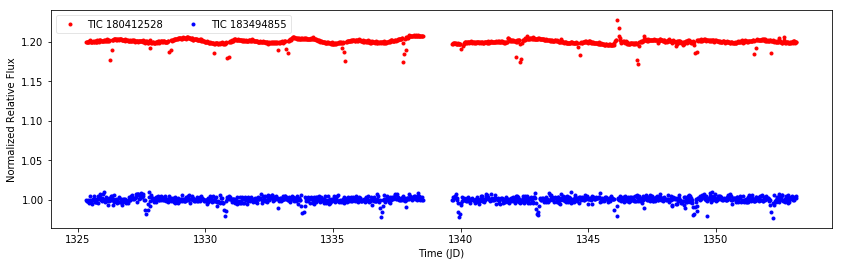

In [24]:
newtime1,newflux1,newflux_error1,window_size1 = SmoothAndRemove(t1,f1,fe1,10)
newtime2,newflux2,newflux_error2,window_size2 = SmoothAndRemove(t2,f2,fe2,10)

plt.figure(figsize=(14,4))
plt.plot(newtime1,newflux1+0.2,'r.',label='TIC '+ID1)
plt.plot(newtime2,newflux2,'b.',label='TIC '+ID2)
plt.xlabel("Time (JD)")
plt.ylabel("Normalized Relative Flux")
plt.legend(loc='best',ncol=2,fancybox=True,framealpha=0.5)
plt.show()

# BLS:

TIC 180412528


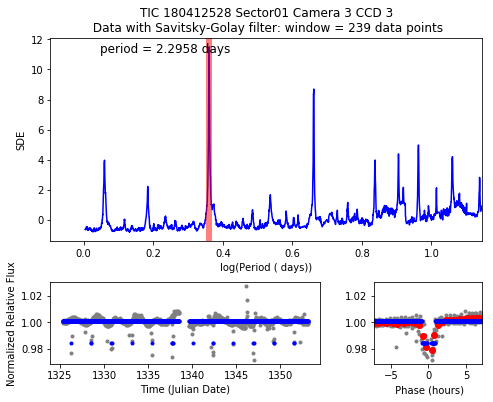

 
TIC 183494855


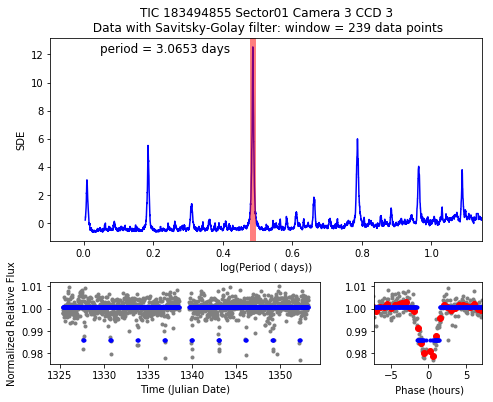

In [28]:
#path where figures will be saved
SectorNum=1
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/'
print ('TIC '+ID1)

minP=1.01 #maxP is length of light curve ~27 days (see BLS function)
minDur = 1.0/24.0
maxDur = 5.0/24.0

bls, bls_power, bls_SDE, BLS_periods, BLS_t0s, BLS_depths, bls_model = BLS(newtime1,newflux1,newflux_error1,ID1,minP,minDur,maxDur,window_size1,4.0)

PlotBLSResults(bls_power.period, bls_SDE,BLS_periods,ID1,Sector1,Camera1,CCD1,window_size1, newtime1,newflux1,newflux_error1, bls_model, BLS_t0s)

print(" ")

print ('TIC '+ID2)

bls, bls_power, bls_SDE, BLS_periods, BLS_t0s, BLS_depths, bls_model = BLS(newtime2,newflux2,newflux_error2,ID2,minP,minDur,maxDur,window_size2,4.0)

PlotBLSResults(bls_power.period, bls_SDE,BLS_periods,ID2,Sector2,Camera2,CCD2,window_size2, newtime2,newflux2,newflux_error2, bls_model, BLS_t0s)

# Now let's see what it looks like with TLS

TIC 180412528
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1255 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads


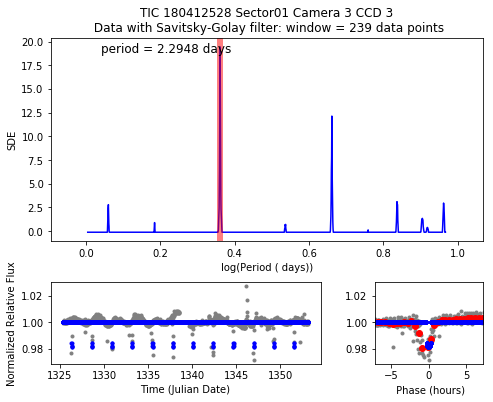

 
TIC 183494855
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 25 durations
Searching 1257 data points, 1726 periods from 1.01 to 9.278 days
Using all 4 CPU threads


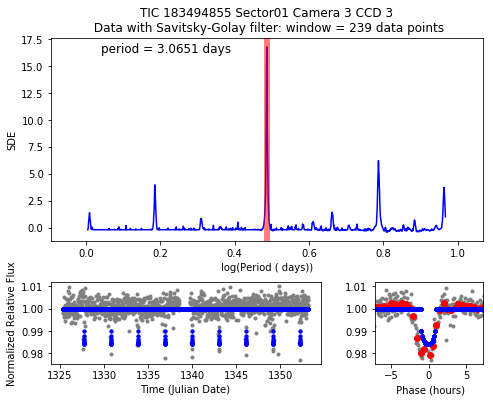

In [30]:
print('TIC '+ID1)
tls1, tls_power1, TLS_SDE1, TLS_periods1, TLS_depths1, TLS_t0s1,TLS_model_time1,TLS_model1 = TLS(newtime1,newflux1,newflux_error1,minP,window_size1)
PlotTLSResults(newtime1, newflux1, newflux_error1, TLS_periods1,TLS_t0s1,tls_power1.periods, TLS_SDE1, ID1, Sector1, Camera1, CCD1, window_size1, TLS_model_time1,TLS_model1)


print(" ")

print('TIC '+ID2)
tls2, tls_power2, TLS_SDE2, TLS_periods2, TLS_depths2, TLS_t0s2,TLS_model_time2,TLS_model2 = TLS(newtime2,newflux2,newflux_error2,minP,window_size2)
PlotTLSResults(newtime2, newflux2, newflux_error2, TLS_periods2,TLS_t0s2,tls_power2.periods, TLS_SDE2, ID2, Sector2, Camera2, CCD2, window_size2, TLS_model_time2,TLS_model2)


# Both BLS and TLS are picking up near identical periodic signals. Let's take a closer look at the transit depths:

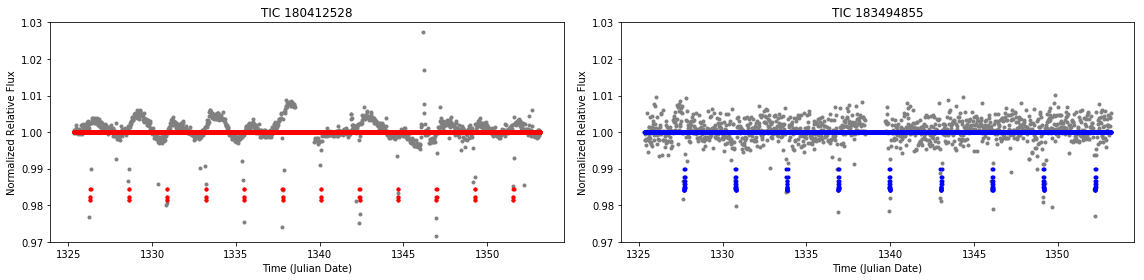

In [57]:
fig=plt.figure(figsize=(16, 4))

fig.add_subplot(121)
plt.plot(newtime1,newflux1,color='grey',marker=".",linestyle='none')
plt.plot(TLS_model_time1,TLS_model1,'r.')
plt.xlabel("Time (Julian Date)")
plt.ylabel("Normalized Relative Flux")
plt.title("TIC "+ID1)
plt.ylim(0.97,1.03)

fig.add_subplot(122)
plt.plot(newtime2,newflux2,color='grey',marker=".",linestyle='none')
plt.plot(TLS_model_time2,TLS_model2,'b.')
plt.xlabel("Time (Julian Date)")
plt.ylabel("Normalized Relative Flux")
plt.title("TIC "+ID2)
plt.ylim(0.97,1.03)

fig.tight_layout()
plt.show()

# Notice that the grey points all have differing depths. Our TLS models assume each transit event has the same transit depth. This is looking like an Eclipsing Binary situation.

# Another way to check this is by looking at the phase folded light curve but instead of centering the transit event on phase 0.0, we'll allow phase to range from 0 to 1:

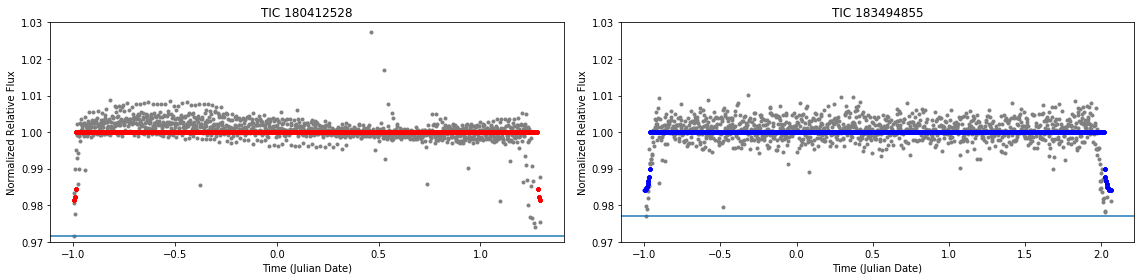

In [72]:
p1 = TLS_periods1
x_fold1 = ((newtime1 - TLS_t0s1 ) % p1 ) -1 # forces phase to range from 0 to 1
pf_model1 = ((TLS_model_time1 - TLS_t0s1 ) % p1 ) -1 # forces phase to range from 0 to 1

p2 = TLS_periods2
x_fold2 = ((newtime2 - TLS_t0s2 ) % p2 ) -1 # forces phase to range from 0 to 1
pf_model2 = ((TLS_model_time2 - TLS_t0s2 ) % p2 ) -1 # forces phase to range from 0 to 1



fig=plt.figure(figsize=(16, 4))

fig.add_subplot(121)
plt.plot(x_fold1,newflux1,color='grey',marker=".",linestyle='none')
plt.plot(pf_model1,TLS_model1,'r.')
plt.xlabel("Time (Julian Date)")
plt.ylabel("Normalized Relative Flux")
plt.title("TIC "+ID1)
plt.ylim(0.97,1.03)
plt.axhline(y=np.min(newflux1))

fig.add_subplot(122)
plt.plot(x_fold2,newflux2,color='grey',marker=".",linestyle='none')
plt.plot(pf_model2,TLS_model2,'b.')
plt.xlabel("Time (Julian Date)")
plt.ylabel("Normalized Relative Flux")
plt.title("TIC "+ID2)
plt.ylim(0.97,1.03)
plt.axhline(y=np.min(newflux2))

fig.tight_layout()
plt.show()

# In this view, it is much easier to notice that the depths are slightly different. 

# The next move is to check SIMBAD and Aladin (can easily find these on Filtergraph)

For TIC 180412528: 
http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=11.3509%20-77.8688&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&Radius=1&Radius.unit=arcsec

It appears this is definitely a double star system also known as L-26-86.

![data1.png](data1.png "TIC 180412528")



For TIC 183494855:

This also appeakrs to be a double star system.

![data2.png](data2.png "TIC 183494855")

# To understand the angular sizes of the apetures used in extracting light curves from the Full Frame Images, see this brief explanation:

![angularsize.png](angularsize.png "Angular Size")


# The aperture sizes Ryan Oelker uses in his pre-processing pipeline are pretty large:


## A TESS pixel covers about 21 arcseconds or 0.35 arcminutes of the sky. Ryan's apeture selection is about 2 pixels or 0.7 arcminutes in radius.

## We can try redoing the photometry with a smaller radius to try and cut out the stellar companion and see if any transit-like signals remain.

(See Photometry Tutorial for following exercise)

In [74]:
import astropy
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits

from lightkurve import search_targetpixelfile
from transitleastsquares import catalog_info



print("TIC ID: ",ID1)
qld1, R_star1, R_star_min1, R_star_max1, M_star1, M_star_min1, M_star_max1 = catalog_info(TIC_ID=int(ID1))
print('Quadratic limb darkening q1, q2: ', qld1[0], qld1[1])
print('Stellar radius: ', R_star1, '+', R_star_max1, '-', R_star_min1, 'solar radii')
print('Stellar mass: ', M_star1, '+', M_star_max1, '-', M_star_min1,'solar mass')
print(" ")

print("TIC ID: ",ID2)
qld2, R_star2, R_star_min2, R_star_max2, M_star2, M_star_min2, M_star_max2 = catalog_info(TIC_ID=int(ID2))
print('Quadratic limb darkening q1, q2: ', qld2[0], qld2[1])
print('Stellar radius: ', R_star2, '+', R_star_max2, '-', R_star_min2, 'solar radii')
print('Stellar mass: ', M_star2, '+', M_star_max2, '-', M_star_min2,'solar mass')
print(" ")

TIC ID:  180412528
Quadratic limb darkening q1, q2:  0.5221 0.3406
Stellar radius:  0.544 + 0.097 - 0.097 solar radii
Stellar mass:  0.506 + 0.075 - 0.075 solar mass
 
TIC ID:  183494855
Quadratic limb darkening q1, q2:  0.1933 0.5347
Stellar radius:  0.186082 + 0.0200794 - 0.0200794 solar radii
Stellar mass:  0.216997 + 0.00650936 - 0.00650936 solar mass
 


In [75]:
starName1 = "TIC " + str(int(ID1))
starName2 = "TIC " + str(int(ID2))

radSearch = 0.5 / 60 # angular radius in degrees

catalogData1 = Catalogs.query_object(starName1, radius = radSearch, catalog = "TIC")
catalogData2 = Catalogs.query_object(starName2, radius = radSearch, catalog = "TIC")


In [76]:
ra1 = catalogData1[0]['ra']; dec1 = catalogData1[0]['dec']

# Print out the first row in the table
print( catalogData1[:5]['ID', 'Tmag', 'Vmag', 'ra', 'dec', 'objType'] )

print(" ")

ra2 = catalogData2[0]['ra']; dec2 = catalogData2[0]['dec']

# Print out the first row in the table
print( catalogData2[:5]['ID', 'Tmag', 'Vmag', 'ra', 'dec', 'objType'] )

    ID      Tmag    Vmag         ra               dec        objType
--------- ------- ------- ---------------- ----------------- -------
180412528  10.758  12.794          11.3509          -77.8688    STAR
612216474 11.3818 13.1398 11.3515768114262 -77.8686456492695    STAR
612216475 12.6674      -- 11.3498954438003 -77.8690341624684    STAR
180415396  13.905      --        11.349535        -77.866951    STAR
612216469  19.146 20.5679 11.3801867475259 -77.8738889501774    STAR
 
    ID      Tmag    Vmag         ra               dec        objType
--------- ------- ------- ---------------- ----------------- -------
183494855 12.9132    17.1 18.3811989111168 -76.0525772361905    STAR
612236989 18.3214 19.0697 18.3733931048585 -76.0564183970628    STAR
183493519 16.5506 17.6325 18.3632172901324 -76.0496828064511    STAR
612236993 20.4656 21.1689 18.3775434683808 -76.0471050705483    STAR
612236988 19.0438 19.9296 18.3969455917166 -76.0573977689516    STAR


In [77]:
#Lets make a brightness cut to remove anything brighter than 17 TESS Magnitude (Tmag).

bright1 = catalogData1['Tmag'] < 17 #TESS magnitude
bright2 = catalogData2['Tmag'] < 17 #TESS magnitude

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars1 = list( map( lambda x,y:[x,y], catalogData1[bright1]['ra'], catalogData1[bright1]['dec'] ) )
print(nearbyStars1)

print(" ")
nearbyStars1 = list( map( lambda x,y:[x,y], catalogData2[bright2]['ra'], catalogData2[bright2]['dec'] ) )
print(nearbyStars1)

[[11.3509, -77.8688], [11.3515768114262, -77.8686456492695], [11.3498954438003, -77.8690341624684], [11.349535, -77.866951]]
 
[[18.3811989111168, -76.0525772361905], [18.3632172901324, -76.0496828064511]]


In [78]:
coord1 = SkyCoord(ra1, dec1, unit = "deg")
sectorTable1 = Tesscut.get_sectors(coord1)
print(sectorTable1)

print(" ")
coord2 = SkyCoord(ra2, dec2, unit = "deg")
sectorTable2 = Tesscut.get_sectors(coord2)
print(sectorTable2)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-3-3      1      3   3
 
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-3-3      1      3   3


In [79]:
cutoutsize=1 #pixel.

hdulist1 = Tesscut.get_cutouts(coord1)#, cutoutsize) #number is pixel cutout?
for ii in range(len(hdulist1)):
    print(hdulist1[ii]) #if blank, does that mean no cutout is available yet?
    print(" ")


hdulist1[0].info()
print(" ")


hdulist2 = Tesscut.get_cutouts(coord2)#, cutoutsize) #number is pixel cutout?
for ii in range(len(hdulist2)):
    print(hdulist2[ii]) #if blank, does that mean no cutout is available yet?
    print(" ")


hdulist2[0].info()
print(" ")

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1c2922ab70>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1c29230470>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c292e8dd8>]
 
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    278   1282R x 12C   [D, E, J, 25J, 25E, 25E, 25E, 25E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       146   (5, 5)   int32   
 
[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1c292f6e80>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1c2931b2e8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c2932ec50>]
 
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    278   1282R x 12C   [D, E, J, 25J, 25E, 25E, 25E, 25E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       146   (5, 5)  

In [80]:
def plot_cutout_ax(image,ax):
    """
    Plot image and add grid lines.
    """
    ax.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    ax.grid(axis = 'both',color = 'white', ls = 'solid')
    
    

0


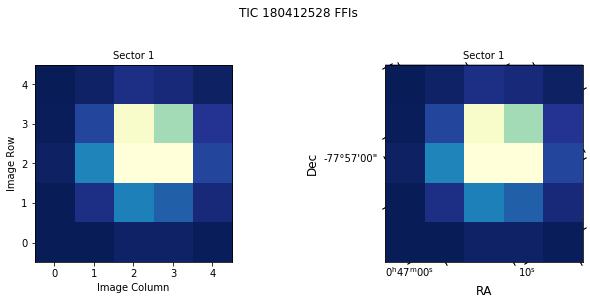

 
0


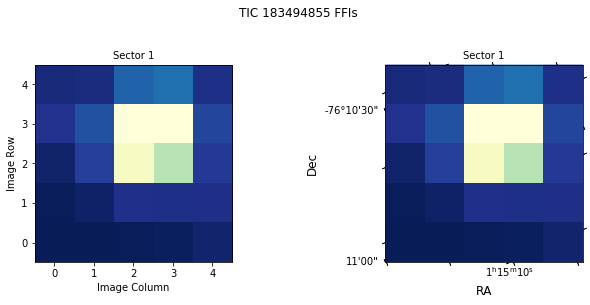

In [83]:
fs=10 #fontsize

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('TIC_'+str(ID1)+'_FFIs.pdf') as pdf: #this is a way to save PDF files of your figures
    for ii in range(len(sectorTable1)):
        print (ii)

        hdu = hdulist1[ii]
        
        Image = hdu[1].data['FLUX'][0] 
        wcs = WCS(hdu[2].header)
        
        pltind = 221
        
        fig = plt.figure(figsize=(12, 8))
        
        fig.add_subplot(pltind).imshow(Image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
               vmax = np.percentile(Image, 92),
               vmin = np.percentile(Image, 5))
        plt.ylabel('Image Row',fontsize = fs) 
        plt.xlabel('Image Column',fontsize = fs)
        plt.title("Sector "+str(hdulist1[ii][0].header['SECTOR']),fontsize = fs)

        
        fig.add_subplot(pltind+1,projection = wcs).imshow(Image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
               vmax = np.percentile(Image, 92),
               vmin = np.percentile(Image, 5))

        plt.title("Sector "+str(hdulist1[ii][0].header['SECTOR']),fontsize = fs)
        plt.xlabel('RA', fontsize = 12)
        plt.ylabel('Dec', fontsize = 12)

        fig.suptitle('TIC '+str(ID1)+' FFIs')
        fig.subplots_adjust(wspace=0.1)#,hspace=0.02)
#         fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    pdf.savefig(bbox_inches='tight')
    plt.show()
    
    
    
print(" ")    
with PdfPages('TIC_'+str(ID2)+'_FFIs.pdf') as pdf: #this is a way to save PDF files of your figures
    for ii in range(len(sectorTable2)):
        print (ii)

        hdu = hdulist2[ii]
        
        Image = hdu[1].data['FLUX'][0] 
        wcs = WCS(hdu[2].header)
        
        pltind = 221
        
        fig = plt.figure(figsize=(12, 8))
        
        fig.add_subplot(pltind).imshow(Image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
               vmax = np.percentile(Image, 92),
               vmin = np.percentile(Image, 5))
        plt.ylabel('Image Row',fontsize = fs) 
        plt.xlabel('Image Column',fontsize = fs)
        plt.title("Sector "+str(hdulist2[ii][0].header['SECTOR']),fontsize = fs)

        
        fig.add_subplot(pltind+1,projection = wcs).imshow(Image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
               vmax = np.percentile(Image, 92),
               vmin = np.percentile(Image, 5))

        plt.title("Sector "+str(hdulist2[ii][0].header['SECTOR']),fontsize = fs)
        plt.xlabel('RA', fontsize = 12)
        plt.ylabel('Dec', fontsize = 12)

        fig.suptitle('TIC '+str(ID2)+' FFIs')
        fig.subplots_adjust(wspace=0.1)#,hspace=0.02)
#         fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    pdf.savefig(bbox_inches='tight')
    plt.show()    

In [84]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )
    error = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )
    return flux,error

In [97]:
# print ("may want to use custom aperture:")
aperture1 = np.array([[0,0,0,0,0],
            [0,1,1,1,0],
            [0,1,1,1,0],
            [0,1,1,1,0],
            [0,0,0,0,0]])
print("Aperture 1")
print(aperture1)


aperture2 = np.array([[0,0,0,0,0],
            [0,0,1,1,0],
            [0,0,1,1,0],
            [0,0,0,0,0],
            [0,0,0,0,0]])

print(" ")
print("Aperture 2")
print(aperture2)


Aperture 1
[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]
 
Aperture 2
[[0 0 0 0 0]
 [0 0 1 1 0]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


TIC 180412528


<Figure size 792x360 with 0 Axes>

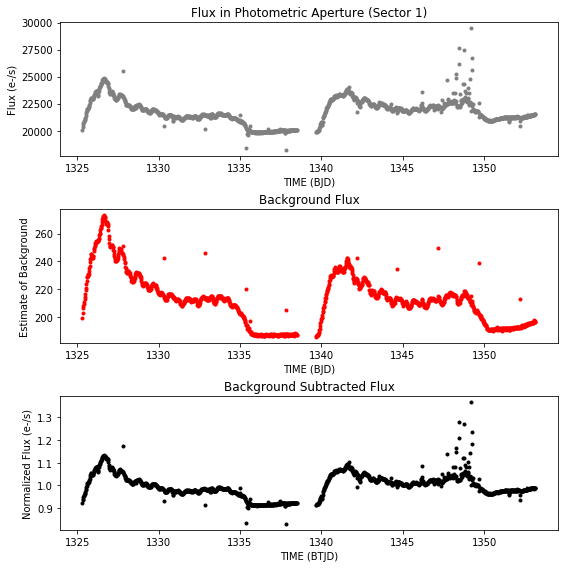

In [99]:
print ("TIC "+ ID1)

rawt1=[];rawf1=[];rawe1=[]
bkgt1=[];bkgf1=[];bkge1=[]
T1=[];F1=[];E1=[]

for ii in range(len(hdulist1)): #number of sector data
    hdu = hdulist1[ii]
    aperture = np.array([[0,0,0,0,0],
            [0,1,1,1,0],
            [0,1,1,1,0],
            [0,1,1,1,0],
            [0,0,0,0,0]])

    #extract raw light curve
    f1 = make_lc(hdu[1].data['FLUX'], aperture)[0]
    e1 = make_lc(hdu[1].data['FLUX_ERR'], aperture)[0]
    t1 = hdu[1].data['TIME'] 
    
    t1 = t1[~np.isnan(t1)] # ~np.isnan() removes NaN (not a number) values from array. Sometimes weird things happen that cause this (telescope errors, known problems,etc).
    f1 = f1[~np.isnan(f1)]
    e1 = e1[~np.isnan(e1)]

    #estimate background flux by checking dimmest pixels by using percentile.
    bkgAperture1 = hdu[1].data['FLUX'][0] < np.percentile(hdu[1].data['FLUX'][0], 5)
    
    bkgFlux1 = make_lc(hdu[1].data['FLUX'], bkgAperture1)[0]
    bkgSubFlux1 = f1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture1) ) #subtracting background flux
    bkgSubFlux1 = bkgSubFlux1[~np.isnan(bkgSubFlux1)]

    #Normalize background subtracted flux
    NormFlux1 = bkgSubFlux1/np.mean(bkgSubFlux1)
    NormFlux1 = NormFlux1[~np.isnan(NormFlux1)]
    
    rawt1=np.append(rawt1,t1)
    rawf1=np.append(rawf1,f1)
    rawe1=np.append(rawe1,e1)
    
    #Background flux data
    bkgFlux1 = bkgFlux1[~np.isnan(bkgFlux1)] 

    bkgt1 = np.append(bkgt1,t1)
    bkgf1 = np.append(bkgf1,bkgFlux1)
    bkge1 = np.append(bkge1,e1)
    

    #background subtracted and normalized data
    NormFlux1 = NormFlux1[~np.isnan(NormFlux1)]
    t1 = t1[~np.isnan(NormFlux1)]
    e1 = e1[~np.isnan(NormFlux1)]

    T1 = np.append(T1,t1)
    F1 = np.append(F1,NormFlux1)
    E1 = np.append(E1,e1)



plt.figure(figsize = (11,5))
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(311)
plt.plot(rawt1,rawf1, color='grey',marker='.',linestyle='none', lw = .5)
plt.xlabel('TIME (BJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture (Sector 1)')

fig.add_subplot(312)
plt.plot(bkgt1, bkgf1, 'r.', lw = .5)
plt.xlabel('TIME (BJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

fig.add_subplot(313)
plt.plot(T1, F1,'.k', lw = 0.5)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Normalized Flux (e-/s)')
plt.title('Background Subtracted Flux')

fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
plt.show()

<Figure size 792x360 with 0 Axes>

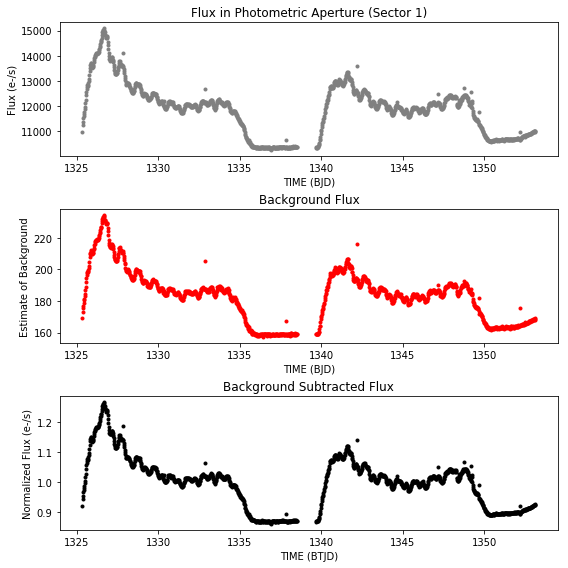

In [101]:
rawt2=[];rawf2=[];rawe2=[]
bkgt2=[];bkgf2=[];bkge2=[]
T2=[];F2=[];E2=[]

for ii in range(len(hdulist2)): #number of sector data
    hdu = hdulist2[ii]
    aperture = np.array([[0,0,0,0,0],
            [0,0,1,1,0],
            [0,0,1,1,0],
            [0,0,0,0,0],
            [0,0,0,0,0]])  #just for this case because cutout is so zoomed in

    #extract raw light curve
    f2 = make_lc(hdu[1].data['FLUX'], aperture)[0]
    e2 = make_lc(hdu[1].data['FLUX_ERR'], aperture)[0]
    t2 = hdu[1].data['TIME'] 
    
    t2 = t2[~np.isnan(t2)] # ~np.isnan() removes NaN (not a number) values from array. Sometimes weird things happen that cause this (telescope errors, known problems,etc).
    f2 = f2[~np.isnan(f2)]
    e2 = e2[~np.isnan(e2)]

    #estimate background flux by checking dimmest pixels by using percentile.
    bkgAperture2 = hdu[1].data['FLUX'][0] < np.percentile(hdu[1].data['FLUX'][0], 5)
    
    bkgFlux2 = make_lc(hdu[1].data['FLUX'], bkgAperture2)[0]
    bkgSubFlux2 = f2 - (bkgFlux2 * np.sum(aperture) / np.sum(bkgAperture2) ) #subtracting background flux
    bkgSubFlux2 = bkgSubFlux2[~np.isnan(bkgSubFlux2)]

    #Normalize background subtracted flux
    NormFlux2 = bkgSubFlux2/np.mean(bkgSubFlux2)
    NormFlux2 = NormFlux2[~np.isnan(NormFlux2)]
    
    rawt2=np.append(rawt2,t2)
    rawf2=np.append(rawf2,f2)
    rawe2=np.append(rawe2,e2)
    
    #Background flux data
    bkgFlux2 = bkgFlux2[~np.isnan(bkgFlux2)] 

    bkgt2 = np.append(bkgt2,t2)
    bkgf2 = np.append(bkgf2,bkgFlux2)
    bkge2 = np.append(bkge2,e2)
    

    #background subtracted and normalized data
    NormFlux2 = NormFlux2[~np.isnan(NormFlux2)]
    t2 = t2[~np.isnan(NormFlux2)]
    e2 = e2[~np.isnan(NormFlux2)]

    T2 = np.append(T2,t2)
    F2 = np.append(F2,NormFlux2)
    E2 = np.append(E2,e2)



plt.figure(figsize = (11,5))
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(311)
plt.plot(rawt2,rawf2, color='grey',marker='.',linestyle='none', lw = .5)
plt.xlabel('TIME (BJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture (Sector 1)')

fig.add_subplot(312)
plt.plot(bkgt2, bkgf2, 'r.', lw = .5)
plt.xlabel('TIME (BJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

fig.add_subplot(313)
plt.plot(T2, F2,'.k', lw = 0.5)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Normalized Flux (e-/s)')
plt.title('Background Subtracted Flux')

fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
plt.show()

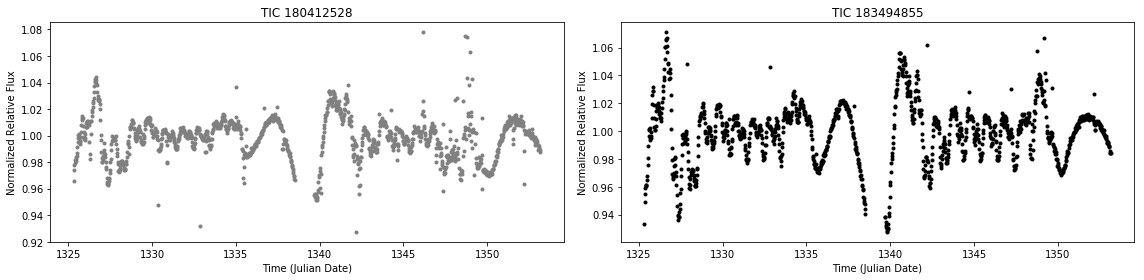

In [108]:
# Let's do smoothing to flatten these out

Newtime1,Newflux1,Newflux_error1,Window_size1 = SmoothAndRemove(T1,F1,E1,1000)
Newtime2,Newflux2,Newflux_error2,Window_size2 = SmoothAndRemove(T2,F2,E2,1000)


fig=plt.figure(figsize=(16, 4))

fig.add_subplot(121)
plt.plot(Newtime1,Newflux1,color='grey',marker=".",linestyle='none')
plt.xlabel("Time (Julian Date)")
plt.ylabel("Normalized Relative Flux")
plt.title("TIC "+ID1)
# plt.ylim(0.97,1.03)

fig.add_subplot(122)
plt.plot(Newtime2,Newflux2,color='black',marker=".",linestyle='none')
plt.xlabel("Time (Julian Date)")
plt.ylabel("Normalized Relative Flux")
plt.title("TIC "+ID2)
# plt.ylim(0.97,1.03)

fig.tight_layout()
plt.show()